## Bias-Variance decomposition example

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def true_dep(x):
    return np.cos((x - 0.2)**2) + 0.2 / (1 + 50 * (x - 0.3)**2)

x_true = np.linspace(0, 1, 100)
y_true = true_dep(x_true)

def generate_n_datasets(num_datasets, dataset_length, noise_power=0.02):
    shape = (num_datasets, dataset_length, 1)
    x = np.random.uniform(size=shape)
    y = true_dep(x) + np.random.normal(scale=noise_power, size=shape)
    return x, y

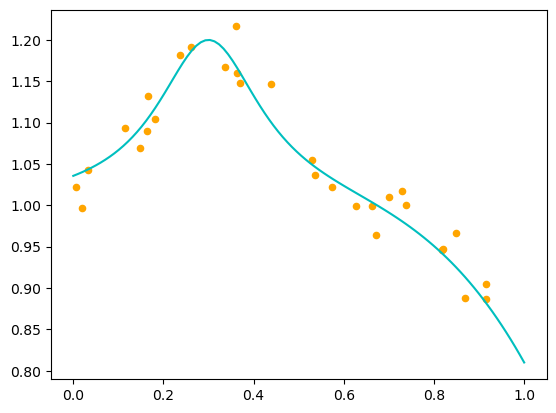

In [10]:
x, y = generate_n_datasets(1, 30)
plt.scatter(x.squeeze(), y.squeeze(), s=20, c='orange')
plt.plot(x_true, y_true, c='c', linewidth=1.5)

In [12]:
from copy import deepcopy
from tqdm import tqdm, trange

In [13]:
def calc_bias2_variance(model, datasets_X, datasets_y):
    preds = []
    for X, y in tqdm(zip(datasets_X, datasets_y), total=len(datasets_X)):
        m = deepcopy(model)
        m.fit(X, y)
        preds.append(m.predict(x_true[:,np.newaxis]).squeeze())
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    bias2 = (y_true - mean_preds) ** 2
    variance = ((preds - mean_preds[np.newaxis, ...]) ** 2).mean(axis=0)

    return bias2, variance, preds

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

As you can see, we are using the Pipeline once again to both preprocess the feature space and fit the model at once.

In [15]:
MAX_POWER = 6
# степени полинома
powers = np.arange(1, MAX_POWER+1)

bias2, variance, preds = [], [], []
for p in powers:
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=p)),
        ('linear', LinearRegression())
    ])

    b2, v, p = calc_bias2_variance(model, *generate_n_datasets(1000, 20))
    bias2.append(b2)
    variance.append(v)
    preds.append(p)

bias2 = np.array(bias2)
variance = np.array(variance)

100%|██████████| 1000/1000 [00:01<00:00, 904.80it/s]


6it [00:00,  7.22it/s]


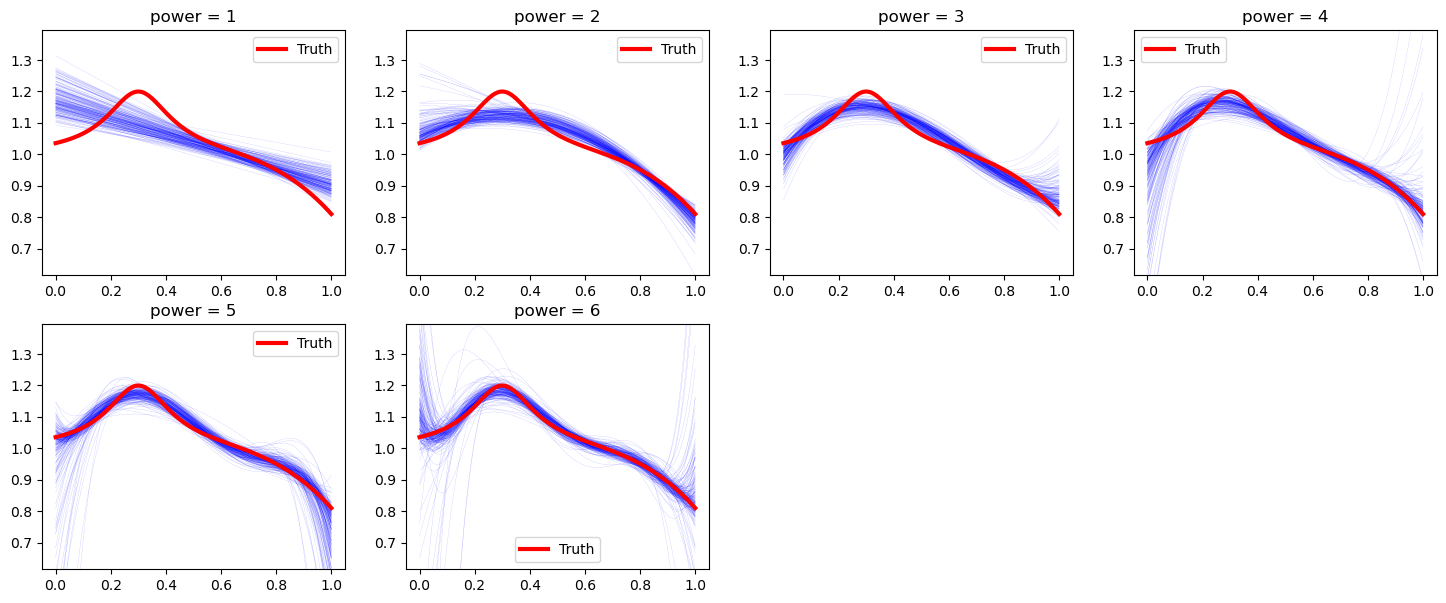

In [16]:
ncols = 4
nrows = int(np.ceil(len(powers) / ncols))

plt.figure(figsize=(18, 3.5 * nrows))

yrange = y_true.max() - y_true.min()

for i, (pred, pow) in tqdm(enumerate(zip(preds, powers), 1)):
    plt.subplot(nrows, ncols, i)
    for p in pred[np.random.choice(len(pred), size=200, replace=False)]:
        plt.plot(x_true, p, linewidth=0.05, c='b');
    plt.plot(x_true, y_true, linewidth=3, label='Truth', c='r')
    plt.ylim(y_true.min() - 0.5 * yrange, y_true.max() + 0.5 * yrange)
    plt.title('power = {}'.format(pow))
    plt.legend();

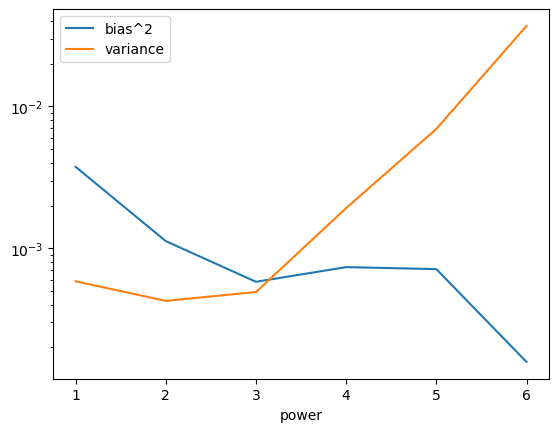

In [18]:
plt.plot(powers, bias2.mean(axis=1), label='bias^2')
plt.plot(powers, variance.mean(axis=1), label='variance')
plt.legend()
plt.yscale('log')
plt.xlabel('power');

## Extra: Runge's phenomenon

Speaking about polinomial features, going to higher degrees does not always improve accuracy. This effect was discovered by Carl David Tolmé Runge (1901) when exploring the behavior of errors when using polynomial interpolation to approximate certain functions. Refer to the wikipedia page for more info.

To observe this phenomenon, let's run the exact same code as above, but with increased maximum power of the polinome.

In [20]:
MAX_POWER = 8
powers = np.arange(1, MAX_POWER+1)

bias2, variance, preds = [], [], []
for p in powers:
    model = Pipeline([
      ('poly', PolynomialFeatures(degree=p)),
      ('linear', LinearRegression())
    ])

    b2, v, p = calc_bias2_variance(model, *generate_n_datasets(1000, 20))
    bias2.append(b2)
    variance.append(v)
    preds.append(p)

bias2 = np.array(bias2)
variance = np.array(variance)

100%|██████████| 1000/1000 [00:01<00:00, 873.16it/s]


8it [00:01,  6.05it/s]


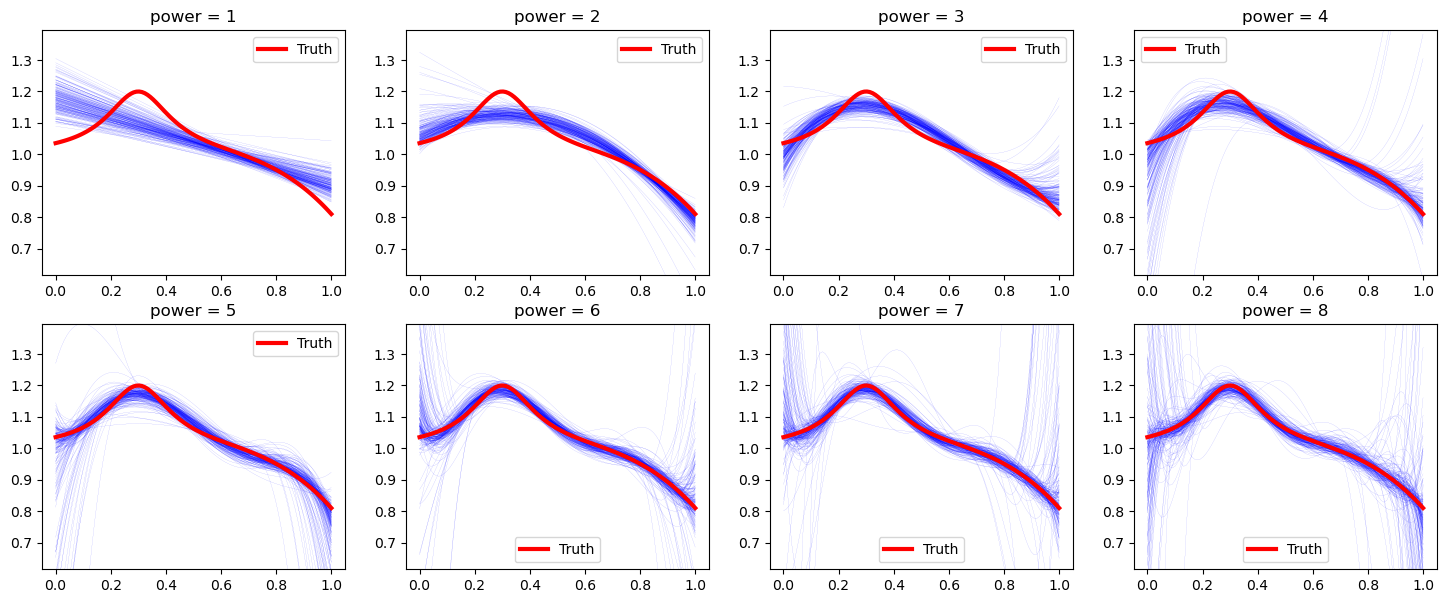

In [21]:
ncols = 4
nrows = int(np.ceil(len(powers) / ncols))

plt.figure(figsize=(18, 3.5 * nrows))

yrange = y_true.max() - y_true.min()

for i, (pred, pow) in tqdm(enumerate(zip(preds, powers), 1)):
    plt.subplot(nrows, ncols, i)
    for p in pred[np.random.choice(len(pred), size=200, replace=False)]:
        plt.plot(x_true, p, linewidth=0.05, c='b');
    plt.plot(x_true, y_true, linewidth=3, label='Truth', c='r')
    plt.ylim(y_true.min() - 0.5 * yrange, y_true.max() + 0.5 * yrange)
    plt.title('power = {}'.format(pow))
    plt.legend();

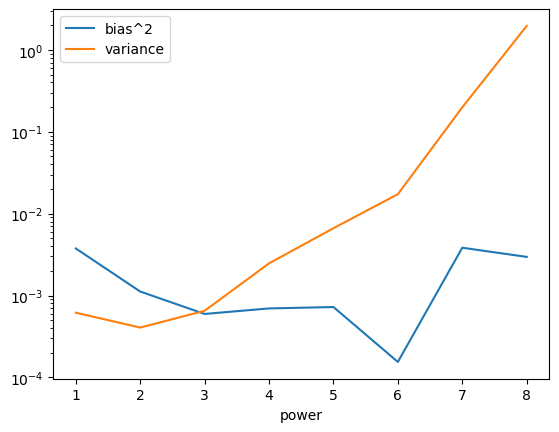

In [22]:
plt.plot(powers, bias2.mean(axis=1), label='bias^2')
plt.plot(powers, variance.mean(axis=1), label='variance')
plt.legend()
plt.yscale('log')
plt.xlabel('power');

As you can see, the bias is increasing after the power equal to 6 as well, but is is caused by the oscillations on the edges of the original function (we are trying to interpolate). Refer to the wiki page for more info.